# Análise de sentimentos em textos

- Este minicurso terá como base os comentário da Amazon, Yelp e IMDb
- Cada dataset contém registros, sendo 1 para reviews Positivos e 0 para Negativos.

In [2]:
import nltk
import spacy

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

warnings.filterwarnings('ignore')
%matplotlib inline

## Análise exploratória dos dados

In [3]:
arquivos_dict = {'amazon': './bases/amazon_cells_labelled.txt',
                 'yelp': './bases/yelp_labelled.txt',
                 'imdb': './bases/imdb_labelled.txt'}

df_list = []

for fonte, arquivos in arquivos_dict.items():
    df = pd.read_csv(arquivos, names=['sentence', 'label'], sep='\t')
    df['fonte'] = fonte
    df_list.append(df)
    
df = pd.concat(df_list)
print('Formato do arquivo {}'.format(df.shape))

Formato do arquivo (19086, 3)


In [3]:
df.sample(10)

,sentence,label,fonte
6334,"So, this does work with every phone.The sound ...",NaN,amazon
12202,Loud and clear in most all situations.,NaN,amazon
12670,"Wow, what a difference.",NaN,amazon
586,I strongly advise against signing up through A...,NaN,amazon
1795,Too hot to wait outside.,NaN,yelp
8779,Smudges and scratches are all you notice plus ...,NaN,amazon
11591,Don't buy used batteries.,NaN,amazon
7168,Camera is O.K.,NaN,amazon
462,The earbuds would fall if you don't wear them ...,NaN,amazon
12566,earbud not too good.,NaN,amazon


#### Verificando a quantidades de amostrar com valores nulos

In [4]:
df.isnull().sum()

sentence        0
label       16338
fonte           0
dtype: int64

In [5]:
df.dropna(inplace=True)
df.sample(10)

,sentence,label,fonte
2728,It's pretty easy.,1.0,amazon
2913,"You can not answer calls with the unit, never ...",0.0,amazon
560,A standout scene.,1.0,imdb
658,I highly doubt that anyone could ever like thi...,0.0,imdb
2751,I probably won't be coming back here.,0.0,yelp
1313,Oh and I forgot to also mention the weird colo...,0.0,amazon
791,I love all the features and form factor.,1.0,amazon
181,Do Not Buy for D807...wrongly advertised for D...,0.0,amazon
456,This item is fantastic and works perfectly!,1.0,amazon
545,Tom Wilkinson's character is a man who is not ...,1.0,imdb


Mesmo verificando os dados nulos com a função **isnull()**, em alguns casos os datasets de textos apresentam campos em branco

In [6]:
brancos = []

for indice, senteca, label, fonte in df.itertuples():
    if(senteca.isspace()): # retorna um TRUE se houver apenas um caractere em branco
        brancos.append(i)
        
brancos

[]

# Vamos plotar um WordCloud com os reviews

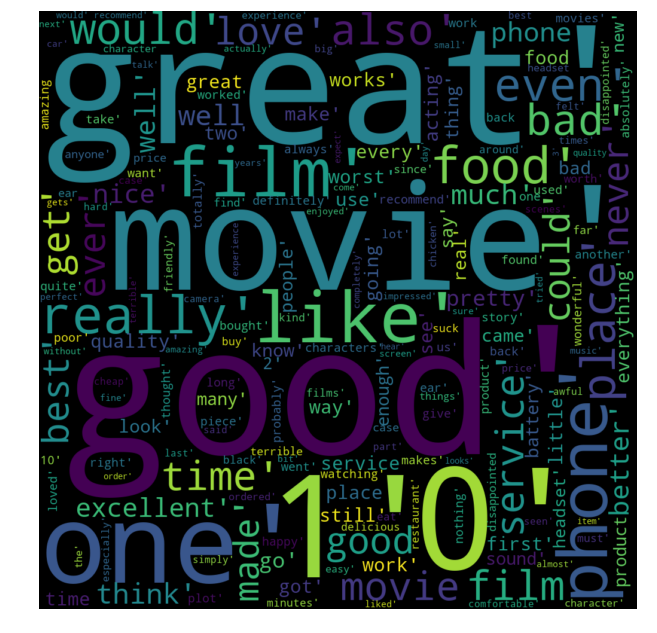

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopwordsNltk = stopwords.words('english')

from wordcloud import WordCloud

words = []

for senteca in df.sentence:
    for palavra in senteca.lower().split():
        if(palavra not in stopwordsNltk):
            words.append(palavra)
            
words = str(words)

wordcloud = WordCloud(width=1000, height=1000, margin=0).generate(words)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)

## Antes de iniciarmos uma análise mais profunda e técnica, podemos procurar padrões “suspeitos” em nosso dataset.

- Será que existe diferença de tamanho (caracteres) do comentário entre os datasets?
- Podemos verificar alguma correlação tamanho do review x sentimento?
- A forma de escrita do comentário (exemplos: educado, rude, gírias, etc…) tem influência no sentimento **positivo** ou **negativo**?

Vamos descobrir através da vizualização dos dados

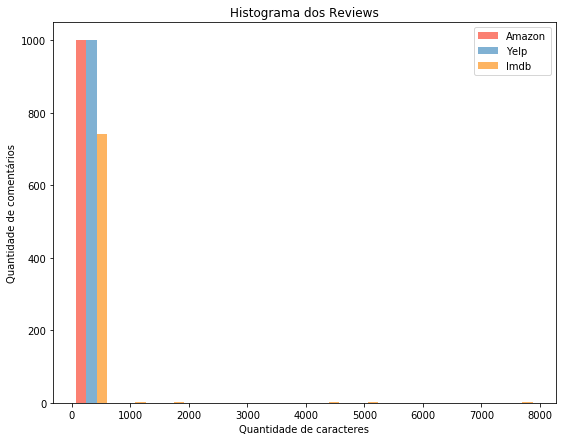

In [8]:
df['tamanho_texto'] = df['sentence'].apply(len)

x1 = list(df[df['fonte'] == 'amazon']['tamanho_texto'])
x2 = list(df[df['fonte'] == 'yelp']['tamanho_texto'])
x3 = list(df[df['fonte'] == 'imdb']['tamanho_texto'])

colors = ['#fb8072', '#80b1d3', '#fdb462']
names = ['Amazon', 'Yelp', 'Imdb']

plt.figure(figsize=(9,7))
plt.hist([x1, x2, x3], bins = int(180/15), normed=False, color = colors, label=names)

plt.xlabel('Quantidade de caracteres')
plt.ylabel('Quantidade de comentários')
plt.title('Histograma dos Reviews')
plt.legend();

Verificando rapidamente o histograma acima, não parece haver distinção entre os Datasets, apenas o Imdb apresenta alguns comentários mais longos que os demais. Mas será que isso influencia no sentimento do comentário: Positivo ou Negativo?

Vamos verificar...

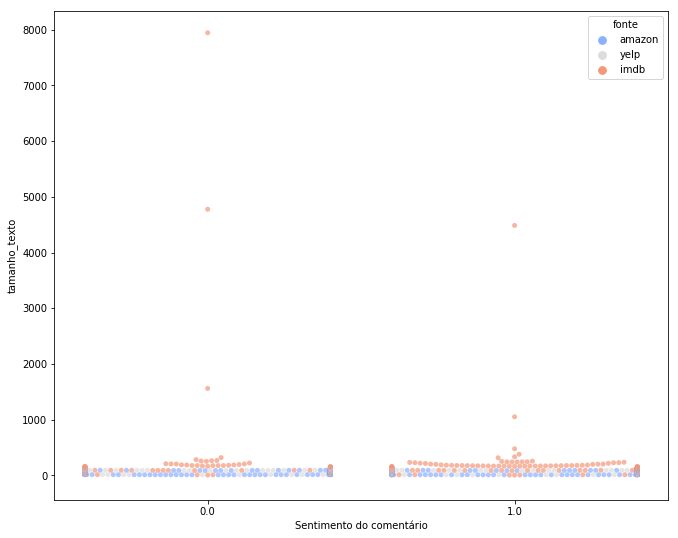

In [9]:
plt.figure(figsize=(11, 9))
sns.swarmplot(x='label', y='tamanho_texto', data=df, hue='fonte', alpha=0.7, palette='coolwarm')
plt.xlabel('Sentimento do comentário');

Conforme mostra nosso swarmplot, não há relação entre o tamanho do comentário com a probabilidade de ser Positivo ou Negativo.

# Vamos análisa gramaticamente os reviews

In [10]:
np.random.seed(100)

negativas = df[df['label'] == 0]
sample_neg = str(negativas.sentence.sample(2).values).split('\n')
positivas = df[df['label'] == 1]
sample_pos = str(positivas.sentence.sample(2).values).split('\n')
print(sample_neg)
print('\n')
print(sample_pos)

["['The real killer is the volume, and of course it breaking.'", " 'This may be the only bad film he ever made.  ']"]


["['Works well.' 'I had strawberry tea, which was good.']"]


In [11]:
nlp = spacy.load('en_core_web_sm')

# Review Negativa

In [12]:
doc = nlp(u"It was just too horrible.")
for token in doc:
    print(f'{token.text:{10}} {token.pos_:{10}} {token.tag_:{5}} {spacy.explain(token.tag)}')

It         PRON       PRP   None
was        AUX        VBD   None
just       ADV        RB    None
too        ADV        RB    None
horrible   ADJ        JJ    None
.          PUNCT      .     None


In [13]:
from spacy import displacy
displacy.render(doc, style='dep', jupyter=True, options={'distance': 128})

# Review Positiva

In [14]:
doc1 = nlp(u"Nevertheless yet another wonderful film from the great master\'s stable.")
displacy.render(doc1, style='dep', jupyter=True, options={'distance': 85})

# Vamos começar efetivamente a análise de sentimento com dataset da Amazon!

![amazon](amazon.png)

- A base de dados será dividida em 80 / 20, sendo respectivamente: Treino e Teste.
- Utilizado Stemming — Refere-se a um processo heurístico não muito refinado que corta as extremidades das palavras na esperança de atingir esse objetivo corretamente na maior parte do tempo, e geralmente inclui a remoção de afixos derivados.

In [15]:
amazon = df[df['fonte'] == 'amazon']
amazon = amazon[['sentence', 'label']]
print('Formato do Dataframe da Amazon {}'.format(amazon.shape))
amazon.head()

Formato do Dataframe da Amazon (1000, 2)


,sentence,label
1,So there is no way for me to plug it in here i...,0.0
2,"Good case, Excellent value.",1.0
5,Great for the jawbone.,1.0
10,Tied to charger for conversations lasting more...,0.0
11,The mic is great.,1.0


In [16]:
amazon['sentence'] = amazon['sentence'].str.replace('[^\w\s]','')

## Divisão da base de dados

In [17]:
from sklearn.model_selection import train_test_split
treino, teste = train_test_split(amazon, test_size=0.2)

In [18]:
print('Shape dos dados de Treino {}'.format(treino.shape))
treino.label.value_counts(normalize=True)

Shape dos dados de Treino (800, 2)


1.0    0.50375
0.0    0.49625
Name: label, dtype: float64

In [19]:
print('Shape dos dados de Teste {}'.format(teste.shape))
teste.label.value_counts(normalize=True)

Shape dos dados de Teste (200, 2)


0.0    0.515
1.0    0.485
Name: label, dtype: float64

# Aplicando Stemmer

In [20]:
treino = [tuple(x) for x in treino.values]

In [21]:
def aplica_stemmer(texto):
    stemmer = nltk.stem.SnowballStemmer('english')
    
    frases_sem_stemming = []
    for (palavras, sentimento) in texto:
        com_stemming = [str(stemmer.stem(p)) for p in palavras.lower().split() if p not in stopwordsNltk]
        frases_sem_stemming.append((com_stemming, sentimento))
    return frases_sem_stemming

In [22]:
frases_com_stem_treinamento = aplica_stemmer(treino)

In [23]:
pd.DataFrame(frases_com_stem_treinamento, columns=['frase', 'sentimento']).sample(10)

,frase,sentimento
162,"[real, improv]",0.0
520,"[return, 8, hour, later]",0.0
188,"[excel, product, satisfi, purchas]",1.0
425,"[super, charg, use, small, hybrid, palmtopcame...",1.0
715,"[piec, junk, broke, phone, 2, day]",0.0
706,"[portabl, work]",1.0
329,"[disappoint, batteri]",0.0
451,"[never, know, push, hard, enough, right, numbe...",0.0
392,"[research, develop, divis, obvious, know, theyr]",1.0
728,"[absolut, problem, headset, link, 8530, blackb...",1.0


In [24]:
teste = [tuple(x) for x in teste.values]
frases_com_stem_teste = aplica_stemmer(teste)

In [25]:
def busca_palavras(frases):
    todas_palavras = []
    for (palavras, sentimento) in frases:
        todas_palavras.extend(palavras)
    return todas_palavras

In [26]:
palavras_treinamento = busca_palavras(frases_com_stem_treinamento)
palavras_teste = busca_palavras(frases_com_stem_teste)

In [27]:
print('Quantidade de palavras na base de treinamento {}'.format(pd.DataFrame(palavras_treinamento).count()))

Quantidade de palavras na base de treinamento 0    4299
dtype: int64


# Listando palavras mais populares

In [28]:
def busca_frequencia(palavras):
    palavras = nltk.FreqDist(palavras)
    return palavras

In [29]:
frenquencia_treinamento = busca_frequencia(palavras_treinamento)
frenquencia_treinamento.most_common(10)

[('phone', 136),
 ('work', 88),
 ('great', 73),
 ('good', 65),
 ('use', 54),
 ('headset', 46),
 ('product', 45),
 ('qualiti', 43),
 ('batteri', 40),
 ('sound', 38)]

In [30]:
frenquencia_teste = busca_frequencia(palavras_teste)
frenquencia_teste.most_common(10)

[('phone', 37),
 ('work', 24),
 ('great', 24),
 ('use', 17),
 ('product', 11),
 ('well', 11),
 ('like', 10),
 ('good', 10),
 ('headset', 9),
 ('realli', 8)]

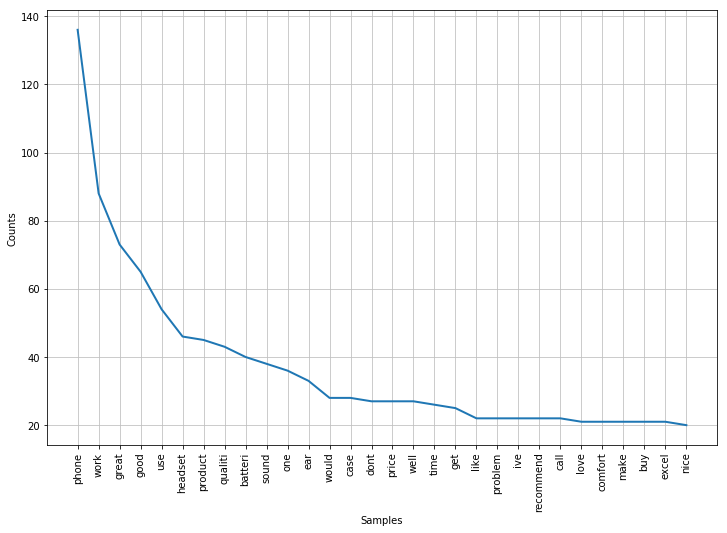

In [31]:
plt.figure(figsize=(12,8))
frenquencia_treinamento.plot(30, cumulative=False);

# Buscando palavras unicas

In [32]:
def busca_palavras_unicas(frequencia):
    freq = frequencia.keys()
    return freq

palavras_unicas_treinamento = busca_palavras_unicas(frenquencia_treinamento)
palavras_unicas_teste = busca_palavras_unicas(frenquencia_teste)

In [33]:
def extrator_palavras(documento):
    doc = set(documento)
    caracteristicas  = {}
    for palavras in palavras_unicas_treinamento:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [34]:
def extrator_palavras_teste(documento):
    doc = set(documento)
    caracteristicas  = {}
    for palavras in palavras_unicas_teste:
        caracteristicas['%s' % palavras] = (palavras in doc)
    return caracteristicas

In [35]:
base_completa_treinamento = nltk.classify.apply_features(extrator_palavras, frases_com_stem_treinamento)
base_completa_teste = nltk.classify.apply_features(extrator_palavras_teste, frases_com_stem_teste)

In [36]:
classificador = nltk.NaiveBayesClassifier.train(base_completa_treinamento)
print(classificador.labels())

[0.0, 1.0]


In [37]:
print('Acurácia: {}%'.format(nltk.classify.accuracy(classificador, base_completa_teste)))

Acurácia: 0.78%


# Como melhorar o modelo?

- Aumentar a base de dados para o treino e teste, com isso teríamos um modelo mais robusto.
- Testar outros algoritmos e hiperparâmetros.
- Incluir novas StopWords…

# Verificando os erros do modelo

In [38]:
erros = []
for (frase, classe) in base_completa_teste:
    resultado = classificador.classify(frase)
    if resultado != classe:
        erros.append((classe, resultado, frase))

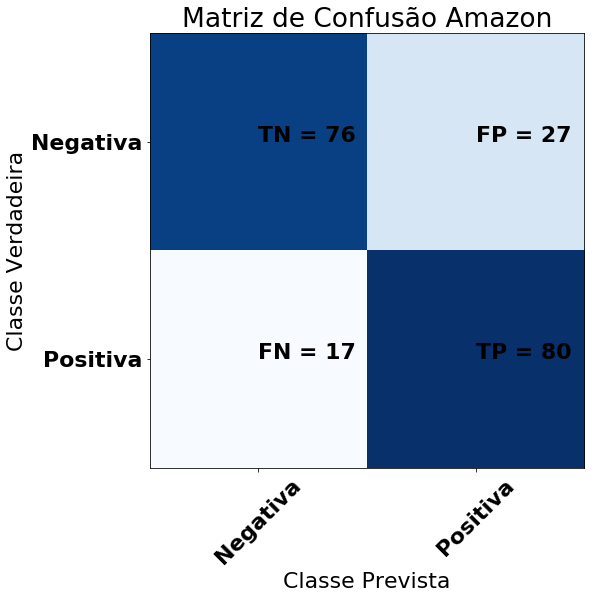

In [40]:
esperado = []
previsto = []
for (frase, classe) in base_completa_teste:
    resultado = classificador.classify(frase)
    previsto.append(resultado)
    esperado.append(classe)

    
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 22}    

plt.rc('font', **font)       
cm = confusion_matrix(esperado, previsto)
plt.figure(figsize=(12, 8))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
className = ['Negativa','Positiva']
plt.title('Matriz de Confusão Amazon')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
tick_marks = np.arange(len(className))
plt.xticks(tick_marks, className, rotation=45)
plt.yticks(tick_marks, className);
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(s[i][j] + " = " + str(cm[i][j])))
plt.show();

# Probabilidade de cada classe

In [41]:
teste = 'i love the movie'
testeStemming = []
stemmer = nltk.stem.SnowballStemmer('english')
for (palavras_treinamento) in teste.split():
    comStem = [p for p in palavras_treinamento.split()]
    testeStemming.append(str(stemmer.stem(comStem[0])))
    
novo = extrator_palavras(testeStemming)
distribuicao = classificador.prob_classify(novo)

for classe in distribuicao.samples():
    print('%s: %f' % (classe, distribuicao.prob(classe)))
    if classe == 0:
        print('Probalidade de ser Negativa')
    else:
        print('Probalidade de ser Positiva')
        

0.0: 0.019410
Probalidade de ser Negativa
1.0: 0.980590
Probalidade de ser Positiva


# Agora vamos realizar a análise de sentimentos da Yelp

![yelp](yelp.png)

In [42]:
yelp = df[df['fonte'] == 'yelp']
yelp = yelp[['sentence', 'label']]
print('Formato do Dataframe da Yelp {}'.format(yelp.shape))
yelp.head()

Formato do Dataframe da Yelp (1000, 2)


,sentence,label
0,Wow... Loved this place.,1.0
3,Crust is not good.,0.0
4,Not tasty and the texture was just nasty.,0.0
10,Stopped by during the late May bank holiday of...,1.0
11,The selection on the menu was great and so wer...,1.0


In [43]:
#criando uma coluna com os índices

yelp['index'] = yelp.index
yelp.head()

,sentence,label,index
0,Wow... Loved this place.,1.0,0
3,Crust is not good.,0.0,3
4,Not tasty and the texture was just nasty.,0.0,4
10,Stopped by during the late May bank holiday of...,1.0,10
11,The selection on the menu was great and so wer...,1.0,11


In [44]:
# Tratando os comentarios para tamanho minúsculo e removendo caracteres especiais e pontuações

yelp.columns = ['Sentence', 'Class', 'index']
yelp['Sentence'] = yelp['Sentence'].str.lower()

yelp['Sentece'] = yelp['Sentence'].str.replace('[^w\s]','')

#Também iremos remover  os numeros

yelp['Sentence'] = yelp['Sentence'].replace('\d', '', regex=True)
df_ = pd.DataFrame(columns=yelp.columns)

In [45]:
#remove stop words

for index, row in yelp.iterrows():
    word_tokens = word_tokenize(row['Sentence'])
    frase_filtrada = [p for p in word_tokens if not p in stopwords.words('english')]
    df_ = df_.append({"index": row['index'], "Class": row['Class'], "Sentence": " ".join(
    frase_filtrada[0:])}, ignore_index=True)

In [46]:
yelp = df_

# A divisão da base de Treino e teste também será de 80/20

X_train, X_test, y_train, y_test = train_test_split(yelp['Sentence'].values.astype('U'),
                                                   yelp['Class'].values.astype('int32'),
                                                   test_size=0.20, random_state=42)

In [47]:
classes = yelp['Class'].unique()
classes

array([1., 0.])

<h3> 

No caso do TFIDF, o único pré-processamento de texto é remover a pontuação e diminuir as letras maiúsculas e minúsculas. Nós não temos que nos preocupar com as StopWords. O TFIDF é a junção do TF e IDF.

</h3>

* O TFIDF é usado com sucesso pelos mecanismos de pesquisa, como o Google, como um fator de classificação para o conteúdo.

* A ideia é pesar os termos freqüentes e aumentar os mais raros.

In [48]:
vectorizer = TfidfVectorizer()
counts = vectorizer.fit_transform(X_train)

In [49]:
vocab = vectorizer.vocabulary_
classifier = SGDClassifier(penalty='elasticnet', random_state=42)
targets = y_train
classifier = classifier.fit(counts, targets)
example_counts = vectorizer.transform(X_test)
previsoes = classifier.predict(example_counts)

In [51]:
print(accuracy_score(y_test, previsoes))

0.755


Nossa acurácia para este modelo foi de **77,5%** utilizando SGDClassifier.    

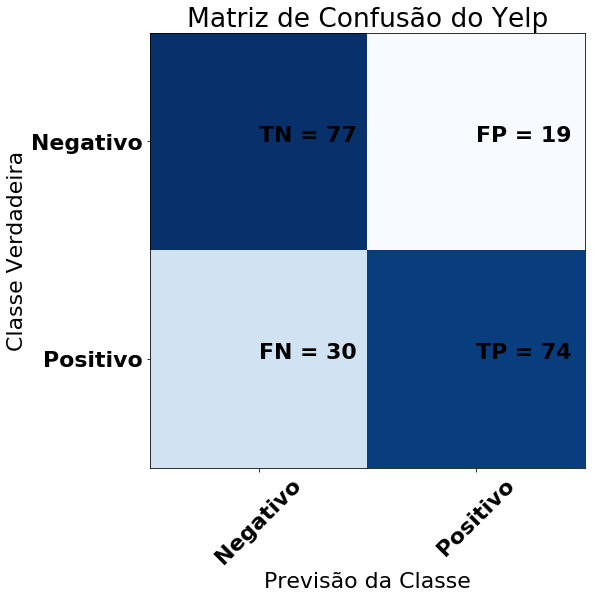

In [59]:
# Caracteristicas das fontes

font = {
    'family' : 'normal',
    'weight' : 'bold',
    'size' : 22}

plt.rc('font', **font)

cm = confusion_matrix(y_test, previsoes)
plt.figure(figsize=(12,8))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
classNames = ['Negativo','Positivo']
plt.title('Matriz de Confusão do Yelp')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Previsão da Classe')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN','TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+' = ' + str(cm[i][j]))

plt.show()



<h3>
    
 Agora que já analisamos os datasets da Amazon e Yelp, temos a atividade com o Imdb

</h3>

* Obs: Nós poderíamos realizar uma única análise de sentimentos com o dataset consolidade que foi importado (concatenação) de todos os conjuntos, porém, o notebook ficará mais completo e didático se tratarmos de forma separada.. Mãos a obra!


<img style='width:500px; height:500px;' src='./imgs/imdb.png'>

In [60]:
imdb = df[df['fonte'] == 'imdb']
imdb = imdb[['sentence', 'label']]
print('Formato do DataFrame do Imdb {}'.format(imdb.shape))
imdb.head()

Formato do DataFrame do Imdb (748, 2)


,sentence,label
0,"A very, very, very slow-moving, aimless movie ...",0.0
1,Not sure who was more lost - the flat characte...,0.0
2,Attempting artiness with black & white and cle...,0.0
3,Very little music or anything to speak of.,0.0
4,The best scene in the movie was when Gerardo i...,1.0


In [61]:
imdb['sentence'] = imdb['sentence'].map(lambda x: x.lower())

#Criamos uma nova coluna e utilizamos a instancia do StopWords criada durante o tratamento da Amazon

imdb['sentence_sem_stop'] = imdb['sentence'].apply(lambda x: ' '.join(p for p in x.split() if p not in
                                                                     stopwordsNltk))

imdb.head()

,sentence,label,sentence_sem_stop
0,"a very, very, very slow-moving, aimless movie ...",0.0,"very, very, slow-moving, aimless movie distres..."
1,not sure who was more lost - the flat characte...,0.0,"sure lost - flat characters audience, nearly h..."
2,attempting artiness with black & white and cle...,0.0,attempting artiness black & white clever camer...
3,very little music or anything to speak of.,0.0,little music anything speak of.
4,the best scene in the movie was when gerardo i...,1.0,best scene movie gerardo trying find song keep...


In [62]:
def num_pos(frase_sem_stop):
    return TextBlob(frase_sem_stop).tags

In [63]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/hermino/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [64]:
sub_a = imdb['sentence_sem_stop'].apply(num_pos)
df_1 = pd.DataFrame(sub_a)

In [65]:
# Criando a nova coluna, cada linha em uma string,

# Onde cada palavra será unida com a sua pos correpondene e um único espaço irá separar as palavras.

df_1['col_pos'] = df_1['sentence_sem_stop'].map(lambda x:" ".join(["/".join(x) for x in x]))

In [66]:
imdb = pd.merge(imdb, df_1, left_index = True, right_index = True,)
imdb.head()

,sentence,label,sentence_sem_stop_x,sentence_sem_stop_y,col_pos
0,"a very, very, very slow-moving, aimless movie ...",0.0,"very, very, slow-moving, aimless movie distres...","[(very, RB), (very, RB), (slow-moving, NN), (a...",very/RB very/RB slow-moving/NN aimless/JJ movi...
1,not sure who was more lost - the flat characte...,0.0,"sure lost - flat characters audience, nearly h...","[(sure, NN), (lost, VBN), (flat, JJ), (charact...",sure/NN lost/VBN flat/JJ characters/NNS audien...
2,attempting artiness with black & white and cle...,0.0,attempting artiness black & white clever camer...,"[(attempting, VBG), (artiness, JJ), (black, JJ...",attempting/VBG artiness/JJ black/JJ &/CC white...
3,very little music or anything to speak of.,0.0,little music anything speak of.,"[(little, JJ), (music, NN), (anything, NN), (s...",little/JJ music/NN anything/NN speak/NN of/IN
4,the best scene in the movie was when gerardo i...,1.0,best scene movie gerardo trying find song keep...,"[(best, JJS), (scene, NN), (movie, NN), (gerar...",best/JJS scene/NN movie/NN gerardo/NN trying/V...


In [67]:
# Novamente estamos dividindo a nossa base em 80/20



In [69]:
X_train, X_test, y_train, y_test = train_test_split(imdb['col_pos'],
                                                   imdb['label'],
                                                   test_size=0.20, random_state=42)

In [70]:
Tfidf = TfidfVectorizer(smooth_idf= True, lowercase= True, sublinear_tf=False, use_idf=True)

X_train_Tfidf = Tfidf.fit_transform(X_train)
X_test_Tfidf = Tfidf.transform(X_test)

In [71]:
def selecao_params(X,y,nfolds):
    Cs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X,y)
    return grid_search.best_params_

In [72]:
# Deixamos o K folds com 5 partições

selecao_params(X_train_Tfidf, y_train, 5)

{'C': 1}

* Como o melhor C encontrado pelo GridSearch foi o C = 1, não precisamos deixar explícito pois o default é este valor. 

In [73]:
clf = SVC(kernel='linear')
clf.fit(X_train_Tfidf, y_train)
previsao = clf.predict(X_test_Tfidf)

In [74]:
print(accuracy_score(y_test,previsao))

0.7733333333333333


# Ufa, terminamos nossa análise de sentimentos para os 3 Datasets

<h4>Para fechar, vamos realizar a análise de sentimentos com um único Dataset, 
    sem diferenciar a fonte dos dados. </h4>

In [75]:
df = df[['sentence', 'label']]
df['index'] = df.index
df.head()

,sentence,label,index
1,So there is no way for me to plug it in here i...,0.0,1
2,"Good case, Excellent value.",1.0,2
5,Great for the jawbone.,1.0,5
10,Tied to charger for conversations lasting more...,0.0,10
11,The mic is great.,1.0,11


In [76]:
df.columns = ['Sentence', 'Class', 'index']
df['Sentence'] = df['Sentence'].str.lower()

df['Sentece'] = df['Sentence'].str.replace('[^w\s]','')

#Também iremos remover  os numeros

df['Sentence'] = df['Sentence'].replace('\d', '', regex=True)
df_ = pd.DataFrame(columns=df.columns)

In [77]:
for index, row in df.iterrows():
    word_tokens = word_tokenize(row['Sentence'])
    frase_filtrada = [p for p in word_tokens if not p in stopwords.words('english')]
    df_ = df_.append({"index": row['index'], "Class": row['Class'], "Sentence": " ".join(
    frase_filtrada[0:])}, ignore_index=True)

In [78]:
df = df_

# A divisão da base de Treino e teste também será de 80/20

X_train, X_test, y_train, y_test = train_test_split(df['Sentence'].values.astype('U'),
                                                   df['Class'].values.astype('int32'),
                                                   test_size=0.20, random_state=42)

In [79]:
classes = df['Class'].unique()
classes

array([0., 1.])

In [80]:
vectorizer = TfidfVectorizer()
counts = vectorizer.fit_transform(X_train)
vocab = vectorizer.vocabulary_
classifier = SGDClassifier(penalty='elasticnet', random_state=42)
targets = y_train
classifier = classifier.fit(counts, targets)
example_counts = vectorizer.transform(X_test)
previsoes = classifier.predict(example_counts)

In [81]:
print(accuracy_score(y_test, previsoes))

0.7818181818181819


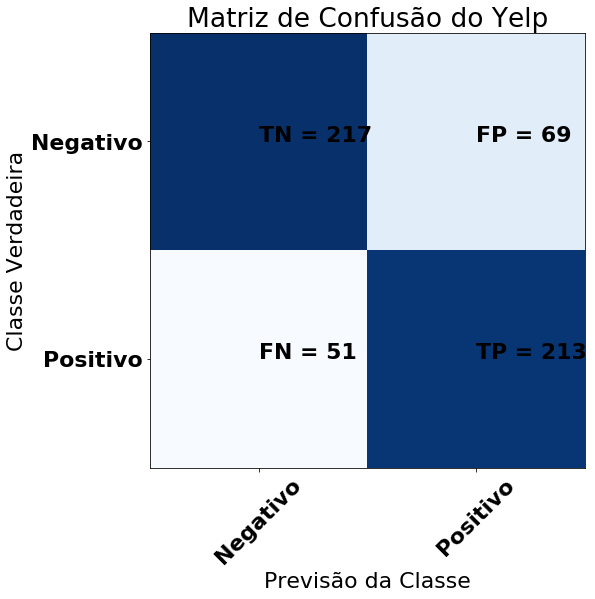

In [83]:
# Caracteristicas das fotes

font = {
    'family' : 'normal',
    'weight' : 'bold',
    'size' : 22}

plt.rc('font', **font)

cm = confusion_matrix(y_test, previsoes)
plt.figure(figsize=(12,8))
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap='Blues')
classNames = ['Negativo','Positivo']
plt.title('Matriz de Confusão do Yelp')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Previsão da Classe')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN','TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i,str(s[i][j])+' = ' + str(cm[i][j]))

plt.show()